In [1]:
import torch
import torchvision
from torch import nn

from custom_datasets import afhqDataset
from models import UnetGenerator
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = (
    UnetGenerator(3, 3, 64, norm_layer=nn.BatchNorm2d, use_dropout=False)
    .cuda()
    .float()
)

checkpoint = torch.load("../../checkpoints_pixandtext/models_5.pth")
generator.load_state_dict(checkpoint["generator_state_dict"])
generator.eval()

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

In [3]:
batch_size = 10
train_ds = afhqDataset("../../afhq/train_contours/")
train_dl = DataLoader(train_ds, batch_size,shuffle=True)

In [5]:
input_img, target_img, label = next(iter(train_dl))
inputs = input_img.to(device)
label = label.type(torch.int32).to(device)
generated_output = generator((inputs, label))

In [6]:
import numpy as np
import cv2

In [8]:
test_img = cv2.imread("../../edges1.png") / 255.0
test_img = cv2.resize(
        test_img, (256, 256), interpolation=cv2.INTER_NEAREST
    )
print(test_img.shape)
test_img = np.array(test_img)
test_img = test_img.astype(np.float32)
test_img = torch.from_numpy(test_img.transpose((2, 0, 1)))
test_img = test_img.unsqueeze(0)
test_img.shape

(256, 256, 3)


torch.Size([1, 3, 256, 256])

In [16]:
test_img = test_img.to(device)
label = torch.Tensor([[0]])
label = label.type(torch.int32).to(device)
test_output_0 = generator((test_img,label))
label = torch.Tensor([[1]])
label = label.type(torch.int32).to(device)
test_output_1 = generator((test_img,label))
label = torch.Tensor([[2]])
label = label.type(torch.int32).to(device)
test_output_2 = generator((test_img,label))

In [17]:
generated_output.shape
normalize=False
if normalize:
        generated_output = generated_output.mul(0.5).add(0.5)

In [13]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


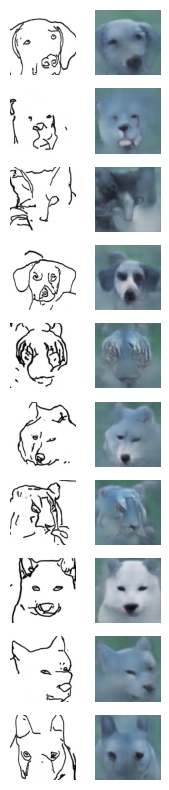

In [14]:
fig = plt.figure(figsize=(2, 10))

for i in range(batch_size):
    fig.add_subplot(batch_size, 2, i*2 +1)
    plt.imshow(input_img[i].cpu().detach().permute(1, 2, 0))
    plt.axis("off")
    fig.add_subplot(batch_size, 2, i*2 +2)
    plt.imshow(generated_output[i].cpu().detach().permute(1, 2, 0))
    plt.axis("off")

plt.show()
# plt.savefig(f"test_17.png")


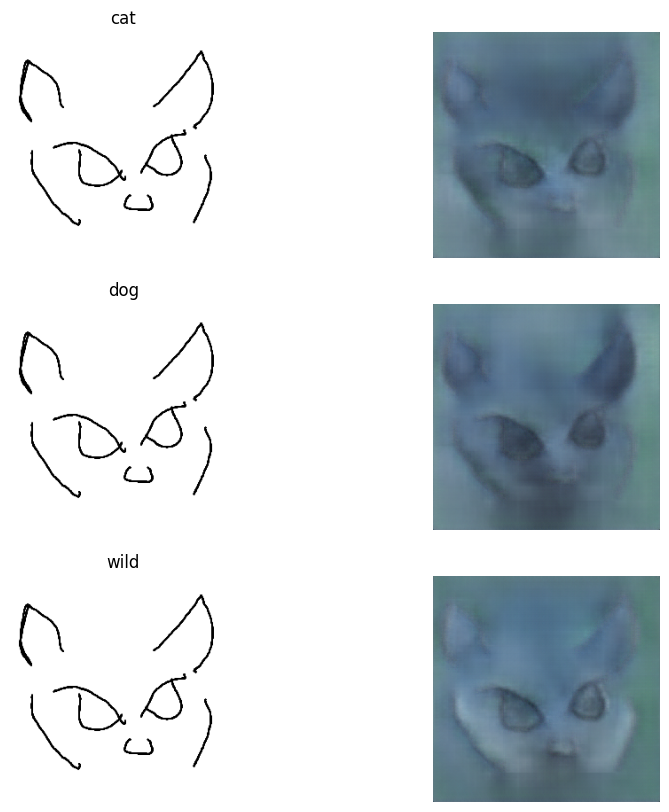

In [30]:
label_dict = ["cat", "dog", "wild"]
fig = plt.figure(figsize=(10, 10))
for i, species in enumerate([test_output_0,test_output_1,test_output_2]):
    fig.add_subplot(3, 2, (i*2+1))
    plt.imshow(test_img[0].cpu().detach().permute(1, 2, 0))
    plt.axis('off')
    plt.title(label_dict[i])
    fig.add_subplot(3, 2, 2*i+2)
    plt.imshow(species[0].cpu().detach().permute(1, 2, 0))
    plt.axis('off')
plt.show()